<a href="https://colab.research.google.com/github/harrysong99/medecal-hw1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Classifying Inlfuenza using VAPOR
By: Alex Nails, Osher Lerner

## First off, Let's recap from Week 1's Lecture and provide some introduction to this assignment. 
We learned what it means to classify, the basics of the machine learning pipeline, and the importance of a model improving as it learns to the data. In this assignment you will learn about a structure called the De Bruijin Graph and engage in a classification assignment. If you're still a little confused on what classification is, we have provided a Linear Classifier Demo in this assignment called **LinearClassifierDemo.ipynb**.

## Here is some background on the Flu
Influenza viruses are enveloped, single-stranded, segmented negative-sense RNA viruses of the family Orthomyxoviridae. Influenza A and B have 8 genome segments encoding major structural and nonstructural proteins, with major antigenic recognition sites within the two spike proteins haemagglutinin (HA) and neuraminidase (NA). Influenza replication in the host cell occurs by means of a viral encoded polymerase that lacks proof-reading capability, leading to frequent point mutations. Accumulation of these point mutations within the antigenic recognition sites of HA and NA can result in host immune evasion, thereby causing annual seasonal epidemics. Current estimates suggest that seasonal influenza A and B cause 4-5 million severe infections in humans with approximately 291,000 to 645,000 deaths per year globally. Whilst influenza B remains largely a human pathogen, influenza type A is a zoonotic virus infecting a
wide range of avian and other non-human species. To date 18 haemagglutinin and 11 neuraminidase types have been recognised, with a reservoir for the majority within birds. These viruses have the
capability to reassort leading to the emergence of new strain. Should these include new HA and NA proteins, pandemic viruses can emerge that completely evade the host response leading to global epidemics of often high morbidity and mortality in both non-human and human hosts.

## Here is some background on past methods.
Whole genome sequencing (WGS) has been used to study the influenza virus genome for over a decade, and is as an important tool in research. Two important data  resources exist to this end; the NCBI Influenza Virus Resource (NIVR), and the Global Initiative on Sharing All Influenza Data (GISAID), wherein over a hundred thousand influenza genome segment sequences can be found from isolates sequenced across the globe. Bioinformatics pipelines have begun to be developed for efficient processing of this data. Despite the increasing application of Next-Generation Sequencing (NGS) to influenza, the pitfalls associated with current mapping approaches have not been explored in depth. Due to diversity of influenza genome sequences, past methods routinely result in a large number of unmapped reads. In turn, this can potentially result in data loss and bias in sequences that are subsequently recovered, analyzed, and submitted to public databases. This has been previously noted in study of human immunodeficiency virus (HIV). Whilst alternatives, such as read classification by mapping to a large database of influenza sequences and subsequent processes can help to resolve this issue, such pipelines are often complex, slow, and require expertise that is not necessarily available in routine surveillance. Secondly, even if bioinformatics pipelines are chosen carefully, sequences of
zoonotic (animals) origin may fail to be identified, resulting in a dataset that appears to be low coverage, missing segments, or missing potential future pandemic reassortments.

## Here is the goal of the assignment
We aim to show that this problem can be resolved by classification of isolates from reads of genetic data prior to WGS/NGS analysis by directly querying a De Bruijn graph (DBG). To further develop a simple method for querying short influenza genome sequences, we leverage the large number of publicly available influenza segment sequences, creating this VAPOR classifier.

### To start coding, first we must import the necessary libaries and assemble our data.

In [ ]:
import sys
import argparse
import os
import numpy as np
from collections import deque
import gzip
import random
#this function sets numpy related objects to be fully printed no matter their size
np.set_printoptions(threshold=sys.maxsize)

As stated in the introduction to the assignment, the main structure behind this classifier utilizes the properties of a De Bruijin Graph. They utilize **kmers**, a set of k long substrings relative to some larger string of genetic data. For example, if the string was 'ATG' and k = 2, you would have 'AT' and 'TG' as kmers. Using kmers, we will build our De Bruijin Graph. 

These kmers are utilized by the graph to build nodes that are subsets of a set of kmers. Each node will have a corresponding weight which relates to how heavily the DNA subsequence is found, allowing us to update the weights and then classify once weights have been sufficiently trained.

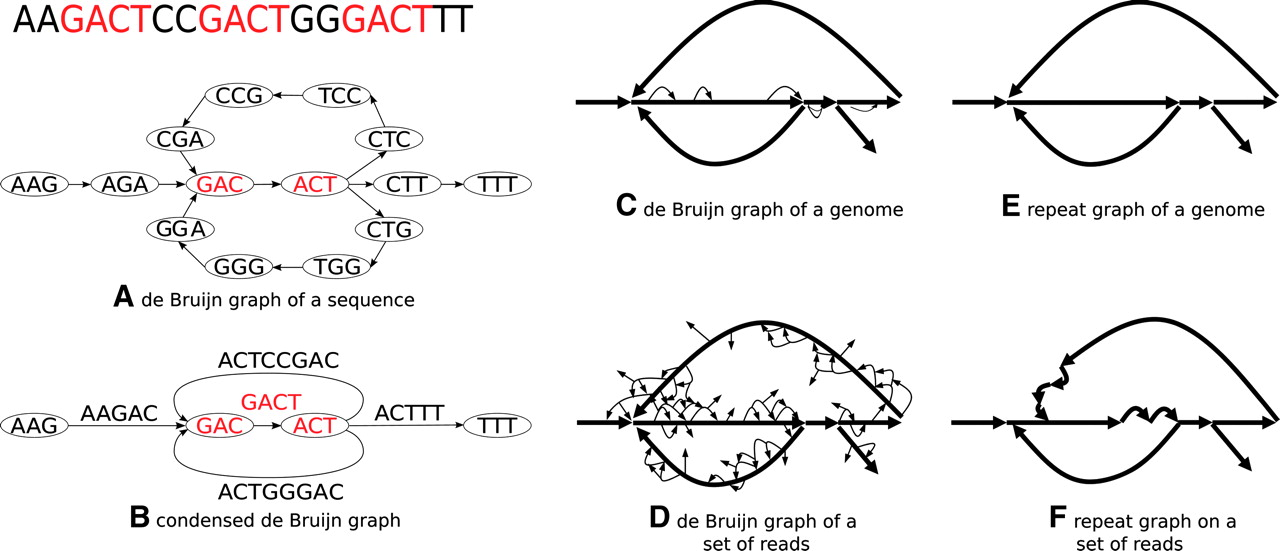

In [ ]:
from IPython.display import Image
Image(filename='dbg.jpg') 

## Look over these helpers functions to make sure you have a rough idea of what they do.

In [ ]:
def kmers2str(kmers):
    """ Takes a set off kmers and extracts their string """
    s = kmers[0]    
    for k in kmers[1:]:
        s += k[-1]
    return s

def get_kmers(strings, k):
    """ Takes strings and returns a set of kmers """
    kmers = []
    for string in strings:
        kmers.append([string[i:i+k] for i in range(len(string)-k+1)])
    return kmers

def get_kmers_set(strings, k):
    """ Takes strings and returns a set of kmers """
    kmers = set()
    for string in strings:
        for kmer in [string[i:i+k] for i in range(len(string)-k+1)]:
            kmers.add(kmer)
    return kmers

def rev_comp(read):
    """ Basic (slow) reverse complement of genetic pairs as well as formatting """
    read = read.replace("T", "a")
    read = read.replace("A", "t")
    read = read.replace("C", "g")
    read = read.replace("G", "c")
    return read.upper()[::-1]

def parse_and_prefilter(fqs, dbkmers, threshold, k):
    """ Parses fastq files (genetic sequence) fqs, and filters them """
    nraw = 0
    reads = []
    c = 0
    with open(fqs, 'r') as file:
        for line in file:
            if c == 1:
                nraw += 1
                stripped = line.strip()
                ktotal = int(len(stripped)/k)
                # Don't allow Ns in read
                # Don't allow reads < k
                rev = rev_comp(stripped)
                for tmpseq in [stripped, rev]: 
                    kcount = 0
                    if "N" not in tmpseq and len(tmpseq) >= k:
                        for i in range(0, len(tmpseq)-k+1, k):
                            if tmpseq[i:i+k] in dbkmers:
                                kcount += 1
                                if kcount/ktotal > threshold:
                                    reads.append(tmpseq)
                                    # As soon as our threshold is exceeded, break
                                    break
            c += 1                  
            if c == 4:
                c = 0
    return reads, nraw

def parse_fasta_uniq(fasta, filter_Ns=True):
    """ Gets unique sequences from a fasta (another format for text-based genetic data), with filtering of Ns"""
    tmph = ""
    tmps = ""
    hs = []
    ss = []
    sseen = set()
    with open(fasta) as f:
        for li, line in enumerate(f):
            l = line.strip()
            if not l.startswith(">"):
                l = l.upper()
            if len(l) == 0:
                continue
            elif l[0] == ">":
                if tmps not in sseen and li > 0:
                    if ((filter_Ns == True) and "N" not in tmps) or filter_Ns == False:
                        hs.append(tmph)
                        ss.append(tmps) 
                        sseen.add(tmps)
                tmph = l
                tmps = ""
            else:
                tmps += l
    hs.append(tmph)
    ss.append(tmps)
    return hs, ss 

### Since we are finished with building the helper functions that have their various utilties, we will now move on to the classifier. 

### There are multiple functions here, marked with a TODO flag. Some come with hints, others do not. The classify function itself is done for you and the goal of this is for you to get familiar, so your work is more OOP. 

In [ ]:
class SearchResult():
    """
    Class to hold search results and methods
    Used for debugging
    """
    def __init__(self):
        # these are explained in seed :)
        self.raw_weight_array = []
        self.kmer_cov = 0
        
        #ignore this
        self.filled_array = []

class wDBG():
    """ Basic DBG with associated edge weights """
    def __init__(self, strings, k):
        """ Initialized with strings, k, and reference kmers """
        # Only explicitly store nodes
        self.nodes = {}
        self.k = k
        self._build(strings)
        self.caching = True
        self.path_cache = {}
        self.max_trim_size = self.k+1

    def _build(self, strings):
        for si, string in enumerate(strings):
            kmers = [string[i:i+self.k] for i in range(len(string)-self.k+1)]
            for kmer in kmers:
                if kmer in self.nodes:
                    self.nodes[kmer] += 1
                else:
                    self.nodes[kmer] = 1

    def cull_low(self, min_cov=5):
        """
        Culls kmers with a coverage less than min_cov
        """
        keyvals = [(k, v) for k, v in self.nodes.items()]
        for key, val in keyvals:
            if val <= min_cov:
                del self.nodes[key]            

    def mask_against_bridge(self, query, bridge, gapl):
        """
        Parameters:
            self: this is an object
            query: string that represents a subsequence
            bridge: string that represnts a different subsequence
            gapl: int that represents relative positions in larger sequence
            
        Returns:
            mask: a list of indices in the larger subsequence that are found
                  by differences in query and bridge, while accounting for relative
                  position
        
        Takes two strings, query and bridge, returning indices in a the list provided 
        (mask) where they differ while taking their relative position 
        into account by using gapl.
        
        Example: an index in an 8 character string could be 0-7, however,
        since this function is used from different substrings you have to account
        for where it is in the overall sequence. We use gapl, the offset, to do that
        by adding to the index where there is a mismatch.
        """
        mask = []
        #TODO: CODE HERE
        for i in range(len(query)):
            if query[i] != bridge[i]:
                mask.append(i + gapl)
        return mask

    def extend_bridge(self, kmer, n, direction, debug=True):
        """
        Walks along the wDBG n positions
        making heuristic locally optimal decisions
        at branches. Returns string, score array
        """
        # First check the cache
        if self.caching == True:
            if (kmer, n, direction) in self.path_cache:
                return self.path_cache[(kmer, n, direction)]
        string = kmer
        scorearr = np.zeros(n)
        if direction == 1:
            si = 0
        else:
            si = -1
        while len(string) < n+self.k:
            if direction == 1:
                poss_nodes = [string[-self.k+1:] + b for b in "ATCG"]
            elif direction == -1:
                poss_nodes = [b + string[:self.k-1] for b in "ATCG"]
            max_score = 0
            max_base = None
            for pe in poss_nodes:
                if pe in self.nodes:
                    tmpscore = self.nodes[pe]
                    if tmpscore > max_score:
                        max_score = tmpscore
                        if direction == 1:
                            max_base = pe[-1]
                        elif direction == -1:
                            max_base = pe[0]
            if max_base != None:
                scorearr[si] = max_score
                if direction == 1:
                    si += 1
                    string += max_base
                elif direction == -1:
                    si -= 1
                    string = max_base + string
            else:
                break
        if direction == 1:
            string = string[len(kmer):]
            string += "X"*(n-len(string))
        elif direction == -1:
            string = string[:-len(kmer)]
            string = "X"*(n-len(string)) + string
        if self.caching == True:
            self.path_cache[(kmer, n, direction)] = (string, scorearr)
        return string, scorearr

    def get_raw_weight_array(self, kmers):
        """
        Parameters:
            kmers: a (very) long list of k-long subsequences of genetic data
            
        Returns: 
            array: an array of weights that is given to us by searching
                   through the nodes of our DBG, seeing if a kmer is present. 
                   If kmer is not present in nodes, it is 0 (done for you with np.zero).
                   
        hint 1: you know you'll need iteration and using two variables (index, value) will be helpful
        hint 2: since your array is already created, all you have to do is index into
              self.nodes using a specifc kmer and index into the premade array itself 
              using an iter value
        """
        array = np.zeros(len(kmers))
        #TODO: CODE HERE
        for i in range(len(kmers)):
            if kmers[i] in self.nodes:
                array[i] = self.nodes[kmers[i]]
        return array
    
    def get_weight_array_gaps(self, array):
        """
        Parameters:
            array: your weight array you just built, you should know what this is
                   right from the function above
            
        Returns:
            gaps: a list of nested lists which are [gapl, gapr] pairs,
                  which specify the interval of which they are 0's in the weight array. 
                  this is done by the index of where the gap starts and ends. should look like
                  [[gapl, gapr],...,[newgapl, newgapr]], where .append() might be useful
                
        hint 1: you know you'll need iteration and using two variables (index, value) will be helpful
        hint 2: the boolean flag in_gap is if the sequence ends with a 0,
                so feel free to ignore it and structure the code differently.
                
        """
        in_gap = False
        gaps = []
        gapl = 0
        gapr = 0
        #TODO: CODE HERE
        for i in range(len(array)):
            if array[i] == 0 and not in_gap:
                in_gap = True
                gapl = i
            elif array[i] != 0 and in_gap:
                in_gap = False
                gapr = i
                gaps.append([gapl, gapr])
            elif i == (len(array) - 1) and in_gap:
                gapr = len(array)
                gaps.append([gapl, gapr]) 
        return gaps    

    def deque_score_bases(self, array):
        """ 
        This is a version of the sliding window maximum problem.
        
        Parameters:
            array: this is your raw_weight array concatenated with 
                   an array of 0's that is k-1 long, since the deque itself
                   is init'ed with a 0.
                   
        Returns:
            local_maxima: an array of local maxima indexes that are listed for every entry.
            This means that if the max for the past 3 iterations has been index 15, the deque
            has kept 15 and added it to local maxima 3 times resulting in [15, 15, 15].
                   
        The goal of this is to find the local max weight in a subset of the array
        
        hint1: subtraction self.k from the iteration you're on could check whether the the deque's
               lowest index was still in the k-long window
            
        hint2: checking to see if the highest index in deque was still the max value in the array window
               and seeing if you need to replace is necessary as well.
        
        Look at https://www.geeksforgeeks.org/sliding-window-maximum-maximum-of-all-subarrays-of-size-k/
        if you are still struggling to understand this. (method 3)
        """ 
        local_maxima = np.zeros(len(array))
        deq = deque(maxlen=self.k)
        deq.append(0)
        #TODO: YOUR CODE HERE
        for i in range(1, len(array)):
            local_maxima[i-1] = array[deq[0]]
            while deq and deq[0] <= i-self.k:
                deq.popleft()
            while deq and array[i] >= array[deq[-1]]:
                deq.pop()
            deq.append(i)
        local_maxima[-1] = array[deq[0]]
        return local_maxima

    def get_suboptimal_branches(self, kmers):
        """
        Walks backward along an array of kmers until a
        step is detected that is suboptimal
        returns positions of these branches
        """
        suboptimal_branches = set()
        bases = list("ATCG")
        for ki, kmer in enumerate(kmers):
            if kmer in self.nodes:
                score = self.nodes[kmer]
                alts = [kmer[:-1] + b for b in bases]
                altscores = [self.nodes[amer] for amer in alts if amer in self.nodes]
                if altscores != []:
                    if score < max(altscores):
                        suboptimal_branches.add(ki)
        return suboptimal_branches 

    def expand_gaps(self, gaps, suboptimal_branches, max_gapr):        
        """ 
        Acts in place to expand gaps to suboptimal branch positions
        takes the most distant sub branch within self.max_trim_size
        """
        for gapi, gap in enumerate(gaps):
            gapl, gapr = gap
            for li in range(max(0, gapl-self.max_trim_size), gapl):
                if li in suboptimal_branches:
                    gaps[gapi][0] = li
                    break
            for ri in range(min(gapr + self.max_trim_size, max_gapr), gapr, -1):
                if ri in suboptimal_branches:
                    gaps[gapi][1] = ri
                    break

    def seed(self, kmers):
        """
        Parameters:
            kmers: a (very) long list of k-long sequences
            
        Returns:
            the updated SearchResult object, with new kmer_cov
            and get_raw_weight_array data.
            
        The DBG is starting its classification with this function 
        by obtaining the relevant data for the iteration the classify function
        is on. The two fields that are updated in sr are kmer_cov and the
        weight array. kmer_cov is the proportion of the number nonzero weights
        to the entire set of weights in this iteration. the raw_weight_array
        is already made, you just have to GET it. After updating the object's
        instances, return it.
        
        hint: np.count_nonzero is pretty helpful for kmer_cov
        """
        sr = SearchResult()
        # TODO: YOUR CODE HERE
        raw_weightings = self.get_raw_weight_array(kmers)
        nonzero_kmer = np.count_nonzero(raw_weightings)
        proportion = nonzero_kmer / len(raw_weightings)
        sr.raw_weight_array = raw_weightings
        sr.kmer_cov = proportion
        return sr

    def complete_query(self, sr, kmers=None, string=None, debug=False):
        if kmers == None:
            kmers = get_kmers([string], self.k)[0]
        kmer_cov = sr.kmer_cov
        raw_weight_array = sr.raw_weight_array
        # Get the gaps
        gaps = self.get_weight_array_gaps(raw_weight_array)
        # Get the suboptimal branches
        sub = self.get_suboptimal_branches(kmers)
        self.expand_gaps(gaps, sub, len(kmers))
        filled_weight_array = raw_weight_array
        all_masks = []
        for gapl, gapr in gaps:
            if gapl != 0 and gapr != len(kmers):
                gapstring = kmers2str(kmers[gapl:gapr])[self.k-1:]
                bridge, bridge_scores = self.extend_bridge(kmers[gapl-1], gapr-gapl, 1, debug)
                bridge_rev, bridge_scores_rev = self.extend_bridge(kmers[gapr], gapr-gapl, -1, debug)
                gapstring_rev = kmers2str(kmers[gapl:gapr])[:-self.k+1]
                if sum(bridge_scores_rev) > sum(bridge_scores):
                    mask = self.mask_against_bridge(gapstring_rev, bridge_rev, gapl)
                    filled_weight_array[gapl:gapr] = bridge_scores_rev
                else:
                    mask = self.mask_against_bridge(gapstring, bridge, gapl)
                    filled_weight_array[gapl:gapr] = bridge_scores

            elif gapr != len(kmers) and gapl == 0:
                gapstring = kmers2str(kmers[gapl:gapr])[self.k-1:]
                bridge, bridge_scores = self.extend_bridge(kmers[gapr], gapr-gapl, -1, debug)
                mask = self.mask_against_bridge(gapstring, bridge, gapl)
                filled_weight_array[gapl:gapr] = bridge_scores

            elif gapl > 0 and gapr == len(kmers):
                gapstring = kmers2str(kmers[gapl:gapr])[self.k-1:]
                bridge, bridge_scores = self.extend_bridge(kmers[gapl-1], gapr-gapl, 1, debug)
                mask = self.mask_against_bridge(gapstring, bridge, gapl)
                filled_weight_array[gapl:gapr] = bridge_scores
            all_masks += mask
        # Deque score
        filled_weight_array = np.concatenate((filled_weight_array, np.zeros(self.k-1)))
        filled_deque_array = self.deque_score_bases(filled_weight_array)
        for maski in all_masks:
            filled_deque_array[maski] = 0
        # Sum, also get estimated pid
        nonzeros = [i for i in filled_deque_array if i > 0]
        est_pid = len(nonzeros)/len(filled_deque_array)
        sr.est_pid = est_pid
        score = sum(nonzeros)
        sr.score = score
        return sr
    
    
    def classify(self, seqs, seqsh, min_kmer_prop, top_seed_frac, debug_query=None, low_mem=False):
        """
        Queries a set of sequences seqs, with headers seqsh,
        parameter min_kmer_prop
        and if debugging, a debug query
        """
        seeds = []
        for si, seq in enumerate(seqs):
            kmers = [seq[i:i+self.k] for i in range(len(seq)-self.k+1)]
            seed = self.seed(kmers)
            seed.index = si
            if seed.kmer_cov > min_kmer_prop:
                seed.kmers = kmers
                seeds.append(seed)

        topseeds = sorted(seeds, key=lambda x:x.kmer_cov, reverse=True)[:int(np.ceil(top_seed_frac*len(seqs)))]

        scores = []
        for seed in topseeds:
            sr = self.complete_query(seed, seed.kmers, None)
            scores.append(sr)

        # Sort the results
        results = sorted(scores, key = lambda x: x.score * x.est_pid, reverse=True)
        return results

Now that the model is finished we must train and test it. Since genetic sequences are unique and De Bruijin relies on mapping, this all looks like it happens behind the scenes since the weights are updated without us ever looking at the weights at indiviudal timesteps. Usually, a large dataset would be split and the model would be saved after training on some unique subset of that dataset and be tested on a different unique subset as validation where we'd be able to see progress over time using a tool (tensorboard or similiar). What makes this specific classifier so amazing is that VAPOR does not require any preprocessing, it is the same as taking a swab of DNA, digitally encoding it, and putting it into a classifier. In comparison, BLAST (basic local alignment seearch tool) requires pre-processing and doesn't deal with mutations nor physical imperfections of isolates that well, so they must be analyzed and "fixed" (Using other algorithms to reformat mutated DNA, based of a likeliness of relation to close genetic strings, an application of genetic phylogenesis/homology). 

In [ ]:
def main():
    
    sys.stderr.write("Loading database sequences\n")
    seqsh, seqs = parse_fasta_uniq('./HA_sample.fa')
    sys.stderr.write("Got %d unique sequences\n" % len(seqs))

    # Get database kmers for filtering
    sys.stderr.write("Getting database kmers\n")
    dbkmersset = get_kmers_set(seqs, 21)
    sys.stderr.write("Got %d database kmers\n" % len(dbkmersset))

    # Parse and pre-filter reads
    sys.stderr.write("Filtering reads\n")
    reads, nrawreads = parse_and_prefilter('./test_reads.fq', dbkmersset, 0.2, 21)
    nreads = len(reads)
    sys.stderr.write("%d of %d reads survived\n" % (nreads,nrawreads))

    # Check there are still sequences remaining
    if nreads == 0:
        sys.stderr.write("Exiting. No virus found in your sequences. Try a lower filtering threshold, or a bigger set of references.\n")
        sys.exit(1)

    # Build the wDBG from reads
    sys.stderr.write("Building wDBG\n")
    wdbg = wDBG(reads, 21)
    sys.stderr.write("Got %d wdbg kmers\n" % len(wdbg.nodes))
    
    # Cull low coverage
    sys.stderr.write("Culling kmers with coverage under %d \n" % 5)
    wdbg.cull_low(5)
    sys.stderr.write("%d kmers remaining\n" % len(wdbg.nodes))

    if len(wdbg.nodes) == 0:
        sys.stderr.write("Zero kmers remaining after culling! Try a lower coverage cutoff -c. \n")
        sys.exit(1)

    # Ask the wdbg to classify
    sys.stderr.write("Classifying\n")
    path_results = wdbg.classify(seqs, seqsh, 0.1, 0.2, None, False)
    results = path_results[:1]
    results = [(sr.index, sr.est_pid, sr.score) for sr in results if sr.score != -1]
    if len(results) == 0:
        sys.stderr.write("No hits. Try a lower -m threshold\n")
        sys.exit(1)

    # Output results
    for c, est_pid, score in results:
        if score != -1:
            slen = len(seqs[c])
            mean = str(score/slen)
            print(str(est_pid) + "\t" + str(score)+"\t"+str(slen)+"\t" +str(mean) + "\t"+ str(nreads) + "\t"+seqsh[c])

**After running the program and getting the flu virus classified and getting its' information, how does the accuracy score match up with BLAST?**

Ans: 97.82% a little bit lower than blast_mean_res

In [ ]:
blast_mean_res = 99.48

main()


Loading database sequences
Got 497 unique sequences
Getting database kmers
Got 34534 database kmers
Filtering reads
1000 of 1000 reads survived
Building wDBG
Got 1674 wdbg kmers
Culling kmers with coverage under 5 
1658 kmers remaining
Classifying


0.9782480893592005	186719.0	1701	109.77013521457965	1000	>cds:ADO12563 A/Chile/3935/2009 2009/07/07 HA H1N1 Human


## After reading the paper for this week, "How to Read a Paper" and completing this assignment, please go to https://forms.gle/SyFb6TtigBuTkJLG7 and submit!

## Congratulations on finishing Assignment 1! If you have any further questions about the assignment or how a classifier works, feel free to email or contact us on Piazza

Thank you Joel Southgate and the Connor Lab for your contributions and work done on this.